# Example 3 -- Quadtree Grid

In [1]:
# import Python packages used for this example
import pathlib as pl
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon, LineString
import flopy
from flopy.utils.gridgen import Gridgen
import geopandas as gp

In [2]:
# set up paths
ws = './ex3'
name = 'mymodel'
gridgen_ws = pl.Path(ws, "gridgen")
gridgen_ws.mkdir(parents=True, exist_ok=True)

# We will work with the same outline of the Kingdom of Saudi Arabia so we can compress the preprocessing steps here 

In [3]:
domaingdf = gp.read_file('./data/ksa_outline.json').to_crs(8836)
bounds = domaingdf.bounds
domain =domaingdf.geometry.values[0]
# define the model grid
Lx = bounds.maxx.values[0]-bounds.minx.values[0]
Ly = bounds.maxy.values[0]- bounds.miny.values[0]
nlay = 1
nrow = 10
delc = np.ceil(Ly / nrow) * np.ones(nrow, dtype=float)
ncol = np.ceil(Lx / delc[0]).astype(int)
delr = delc[0] * np.ones(ncol, dtype=float)
top = 50 * np.ones((nrow, ncol), dtype=float)
botm = -5000 * np.ones((nlay, nrow, ncol), dtype=float)

# create a flopy grid object, which can be used for intersections
sg = flopy.discretization.StructuredGrid(
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
    xoff=bounds.minx.values[0],
    yoff=bounds.miny.values[0],angrot=0, crs=8836
)

## Now, say we wanted to refine the grid around the City of Riyadh?

In [4]:
riyadh = gp.read_file('./data/citylocation.geojson').to_crs(domaingdf.crs)

/Users/mnfienen/miniforge3/envs/flopyswf/lib/python3.11/site-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/Users/mnfienen/miniforge3/envs/flopyswf/lib/python3.11/site-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(


<Axes: >

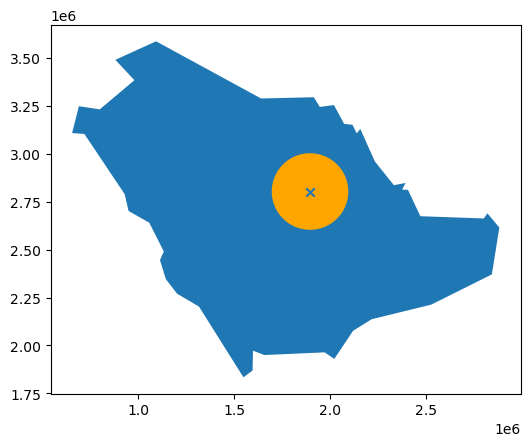

In [5]:
ax = domaingdf.plot()
rbuf = riyadh.buffer(2e5)
rbuf.plot(ax=ax, color='orange')
riyadh.plot(ax=ax,marker='x')


# Now rather than setting the rows and columns for the model, we can make a refined area with verious levels of quadtree refinement. Let's refine around the boundary line and also a buffer around the City of Riyadh

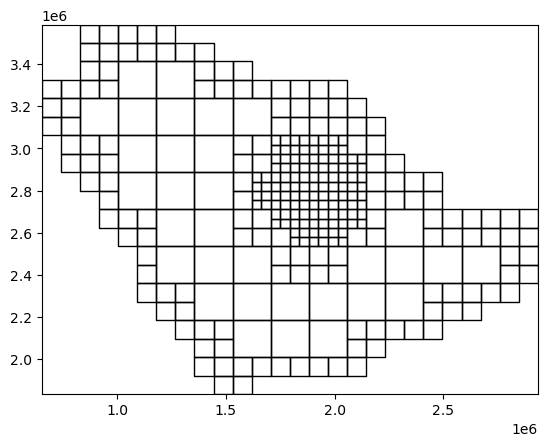

In [6]:
# Use Gridgen to create the unstructured grid
g = Gridgen(sg, model_ws=gridgen_ws, surface_interpolation="interpolate")
g.add_active_domain([domain], range(nlay))
g.add_refinement_features([domain.boundary], "line", level=1, layers=range(nlay))
g.add_refinement_features([rbuf[0]], "polygon", level=2, layers=range(nlay))
g.build()
g.plot()

In [7]:
# create the flopy representation of the MODFLOW simulation
sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=ws, exe_name='mf6')
tdis = flopy.mf6.ModflowTdis(sim)
ims = flopy.mf6.ModflowIms(sim, print_option="all", inner_maximum=100)
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
gridprops_disv = g.get_gridprops_disv()
disv = flopy.mf6.ModflowGwfdisv(
    gwf, **gridprops_disv)
ic = flopy.mf6.ModflowGwfic(gwf, strt=gridprops_disv["top"])
npf = flopy.mf6.ModflowGwfnpf(gwf, save_specific_discharge=True, icelltype=1)

gi = flopy.utils.GridIntersect(gwf.modelgrid)
ls = domain.boundary
chdspd = [[(0, j), 1.] for j in np.array(gi.intersects(ls)["cellids"], dtype=int)]
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chdspd)
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=0.00001)
oc = flopy.mf6.ModflowGwfoc(gwf,
                            budget_filerecord=f"{name}.bud",
                            head_filerecord=f"{name}.hds",
                            printrecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])

In [8]:
# write the MODFLOW input files
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model mymodel...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 91 based on size of stress_period_data
    writing package rcha_0...
    writing package oc...


In [9]:
# run the MODFLOW simulation
sim.run_simulation()

FloPy is using the following executable to run the model: ../../../../../.local/share/flopy/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.2 06/28/2023

   MODFLOW 6 compiled Jul 05 2023 20:29:14 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor th

(True, [])

In [10]:
# load the output from the simulation
head = gwf.output.head().get_data()
bud = gwf.output.budget()
spdis = bud.get_data(text='DATA-SPDIS')[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)

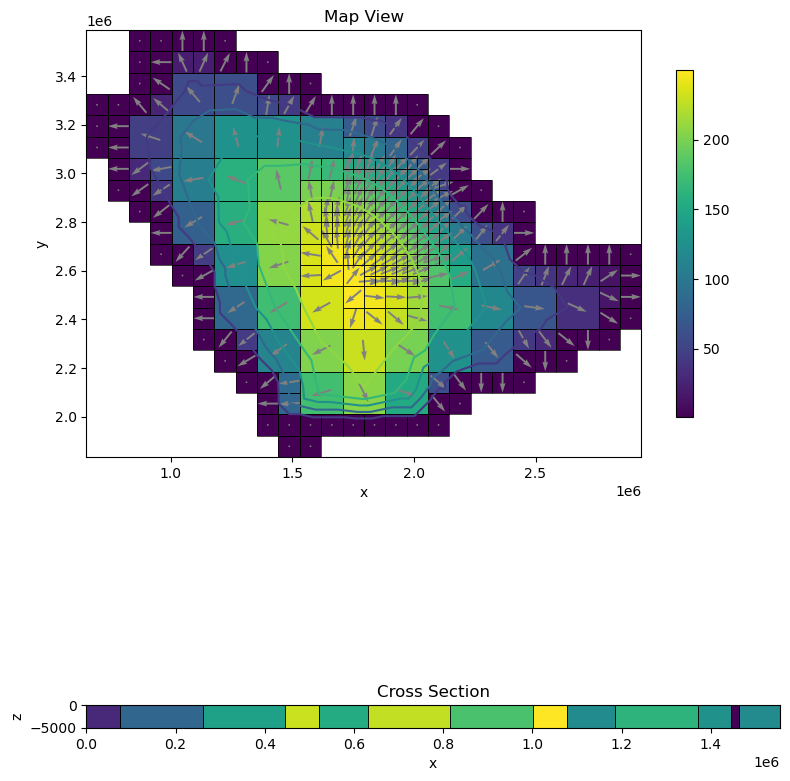

In [11]:
###### create a plot of the model results
fig, axes = plt.subplots(2, 1, figsize=(8, 11))
ax = axes[0]
ax.set_title("Map View")
ax.set_aspect(1)
ax.set_xlabel("x")
ax.set_ylabel("y")
pmv = flopy.plot.PlotMapView(gwf, ax=ax)
pmv.plot_bc(ftype="CHD")
pmv.plot_grid(color="black", linewidth=0.5)
h = pmv.plot_array(head)
pmv.plot_vector(qx, qy, normalize=True, color="grey", istep=1, jstep=1)
pmv.contour_array(head)
plt.colorbar(h, shrink=.6)


ax = axes[1]
ax.set_title("Cross Section")
ax.set_aspect(10.)
ax.set_xlabel("x")
ax.set_ylabel("z")
pxs = flopy.plot.PlotCrossSection(gwf, ax=ax, line={"line": [(1.5e6, 2.0e6), (1e6, 3.5e6)]})
pxs.plot_bc(ftype="CHD")
pxs.plot_array(head, head=head)
pxs.plot_grid(color="black", linewidth=0.5)
plt.tight_layout()